In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
from torchsummary import summary
import os
from sklearn.model_selection import train_test_split, StratifiedKFold


%matplotlib inline

In [2]:
X, y = np.load('./drive/My Drive/mri_data/tensors.npy'), np.load('./drive/My Drive/mri_data/labels.npy')
X = X[:, np.newaxis, :, :, :]
print(X.shape, y.shape)

(1113, 1, 58, 70, 58) (1113,)


In [0]:
class MriData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MriData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## SVM (cross validation)

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [0]:
X_f = X.reshape(X.shape[0], -1).copy()
svc = SVC()
cv_results = cross_val_score(svc, X_f, y, cv=10)

In [28]:
print('Average cross-validation accuracy for SVM (10-folds):', sum(cv_results)/len(cv_results))

Average cross-validation accuracy for SVM (10-folds): 0.9002654440154441


## Non-cross-validation training

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) 
#del X, y #deleting for freeing space on disc

train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)
#del X_train, X_test, y_train, y_test #deleting for freeing space on disc

In [0]:
train_dataset = MriData(X_train, y_train)
test_dataset = MriData(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
hidden = lambda c_in, c_out: nn.Sequential(
    nn.Conv3d(c_in, c_out, (3,3,3)),
    nn.BatchNorm3d(c_out),
    nn.ReLU(),
    nn.MaxPool3d(2)
)

class MriNet(nn.Module):
    def __init__(self, c):
        super(MriNet, self).__init__()
        self.hidden1 = hidden(1, c)
        self.hidden2 = hidden(c, 2*c)
        self.hidden3 = hidden(2*c, 4*c)
        self.linear = nn.Linear(128*5*7*5, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = F.log_softmax(x, dim=1)
        return x

torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNet(c).to(device)
summary(model, (1, 58, 70, 58))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 56, 68, 56]             896
       BatchNorm3d-2       [-1, 32, 56, 68, 56]              64
              ReLU-3       [-1, 32, 56, 68, 56]               0
         MaxPool3d-4       [-1, 32, 28, 34, 28]               0
            Conv3d-5       [-1, 64, 26, 32, 26]          55,360
       BatchNorm3d-6       [-1, 64, 26, 32, 26]             128
              ReLU-7       [-1, 64, 26, 32, 26]               0
         MaxPool3d-8       [-1, 64, 13, 16, 13]               0
            Conv3d-9      [-1, 128, 11, 14, 11]         221,312
      BatchNorm3d-10      [-1, 128, 11, 14, 11]             256
             ReLU-11      [-1, 128, 11, 14, 11]               0
        MaxPool3d-12         [-1, 128, 5, 7, 5]               0
          Flatten-13                [-1, 22400]               0
           Linear-14                   

In [0]:
CHECKPOINTS_DIR =  './drive/My Drive/mri_data/checkpoints/'

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

In [0]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False):
    best_val_loss = 100_000
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []

    train_loss_list.append(get_loss(net, train_loader))
    val_loss_list.append(get_loss(net, val_loader))
    train_acc_list.append(get_accuracy(net, train_loader))
    val_acc_list.append(get_accuracy(net, val_loader))
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        if scheduler is not None:
            scheduler.step()
        
        
        train_loss_list.append(get_loss(net, train_loader))
        val_loss_list.append(get_loss(net, val_loader))
        train_acc_list.append(get_accuracy(net, train_loader))
        val_acc_list.append(get_accuracy(net, val_loader))

        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR+'best_model')
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1]))
        
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list
            
            

In [0]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 20

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False) 

Epoch 00/20 || Loss:  Train 45.9613 | Validation 45.1046
Epoch 01/20 || Loss:  Train 0.4712 | Validation 0.6883
Epoch 02/20 || Loss:  Train 0.2873 | Validation 0.3706
Epoch 03/20 || Loss:  Train 0.2292 | Validation 0.3055
Epoch 04/20 || Loss:  Train 0.2900 | Validation 0.3641
Epoch 05/20 || Loss:  Train 0.2369 | Validation 0.3032
Epoch 06/20 || Loss:  Train 0.1916 | Validation 0.2540
Epoch 07/20 || Loss:  Train 0.1854 | Validation 0.2496
Epoch 08/20 || Loss:  Train 0.1889 | Validation 0.2532
Epoch 09/20 || Loss:  Train 0.1827 | Validation 0.2477
Epoch 10/20 || Loss:  Train 0.1754 | Validation 0.2450
Epoch 11/20 || Loss:  Train 0.1714 | Validation 0.2417
Epoch 12/20 || Loss:  Train 0.1677 | Validation 0.2383
Epoch 13/20 || Loss:  Train 0.1722 | Validation 0.2528
Epoch 14/20 || Loss:  Train 0.1636 | Validation 0.2424
Epoch 15/20 || Loss:  Train 0.1560 | Validation 0.2328
Epoch 16/20 || Loss:  Train 0.1546 | Validation 0.2307
Epoch 17/20 || Loss:  Train 0.1541 | Validation 0.2299
Epoch 18

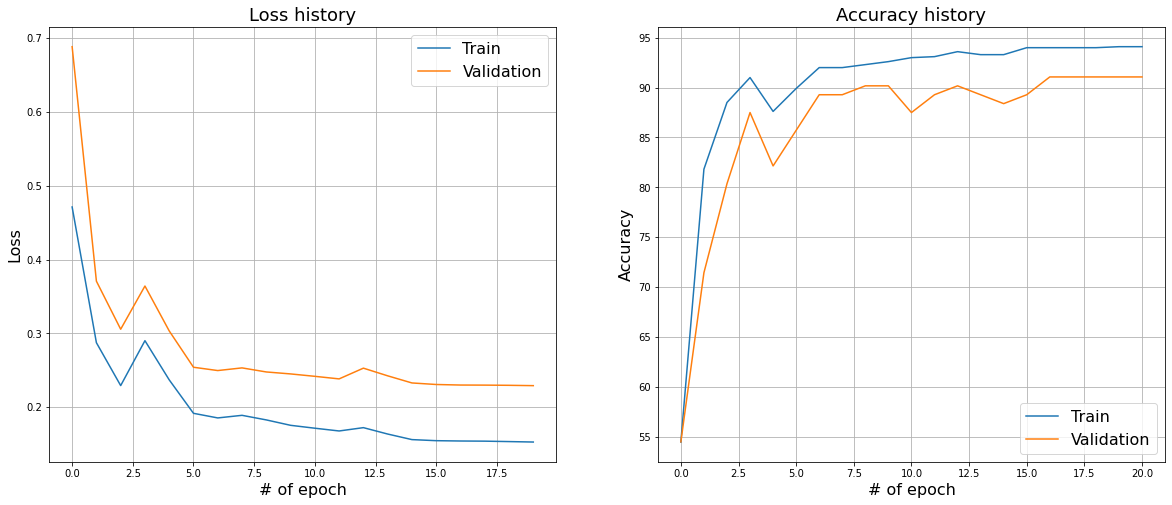

In [0]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.plot(train_loss_list[1:], label='Train')
plt.plot(val_loss_list[1:], label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Accuracy history', fontsize=18)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.xlabel('# of epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=16)
plt.grid()







## K-Fold training

In [0]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0

for train_index, test_index in skf.split(X, y):
    print('Doing {} split'.format(j))
    j += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_dataset = MriData(X_train, y_train)
    test_dataset = MriData(X_test, y_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=28, shuffle=False) 
    
    torch.manual_seed(1)
    np.random.seed(1)

    c = 32
    model = MriNet(c).to(device)
    criterion = nn.NLLLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

    train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader))


Doing 0 split
Doing 1 split
Doing 2 split
Doing 3 split
Doing 4 split
Doing 5 split
Doing 6 split
Doing 7 split
Doing 8 split
Doing 9 split


In [0]:
print('Average cross-validation accuracy (10-folds):', sum(cross_vall_acc_list)/len(cross_vall_acc_list))

Average cross-validation accuracy (10-folds): 91.29263229370117


## Training model on whole data and saving it


In [0]:
dataset = MriData(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize

torch.manual_seed(1)
np.random.seed(1)

model = MriNet(c).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)

train(EPOCHS, model, criterion, optimizer, loader, loader, scheduler=scheduler, save=True, verbose=False) 
pass